# Rename

In [43]:
import os

import os

def rename_images_in_folders(parent_directory: str):
    # Iterate over each folder in the parent directory
    for folder_name in os.listdir(parent_directory):
        folder_path = os.path.join(parent_directory, folder_name)
        if os.path.isdir(folder_path):
            # Get all image files in the folder
            image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff'))]
            # Sort image files to maintain a consistent order
            image_files.sort()
            # Rename each image file to a number from 1 to N
            for index, image_file in enumerate(image_files, start=1):
                # Get the file extension
                file_extension = os.path.splitext(image_file)[1]
                # Create the new file name as a sequential number with the original extension
                new_file_name = f'{index}{file_extension}'
                old_file_path = os.path.join(folder_path, image_file)
                new_file_path = os.path.join(folder_path, new_file_name)
                # Rename the file (this automatically removes the old file)
                os.rename(old_file_path, new_file_path)
                print(f'Renamed: {old_file_path} -> {new_file_path}')

# Example usage
parent_directory = '/Users/judecao/MUN/Winter2025/DSP/Project/Citrus_indoor/Leaves'
rename_images_in_folders(parent_directory)


Renamed: /Users/judecao/MUN/Winter2025/DSP/Project/Citrus_indoor/Leaves/canker/1.png -> /Users/judecao/MUN/Winter2025/DSP/Project/Citrus_indoor/Leaves/canker/1.png
Renamed: /Users/judecao/MUN/Winter2025/DSP/Project/Citrus_indoor/Leaves/canker/10.png -> /Users/judecao/MUN/Winter2025/DSP/Project/Citrus_indoor/Leaves/canker/2.png
Renamed: /Users/judecao/MUN/Winter2025/DSP/Project/Citrus_indoor/Leaves/canker/11.png -> /Users/judecao/MUN/Winter2025/DSP/Project/Citrus_indoor/Leaves/canker/3.png
Renamed: /Users/judecao/MUN/Winter2025/DSP/Project/Citrus_indoor/Leaves/canker/12.png -> /Users/judecao/MUN/Winter2025/DSP/Project/Citrus_indoor/Leaves/canker/4.png
Renamed: /Users/judecao/MUN/Winter2025/DSP/Project/Citrus_indoor/Leaves/canker/13.png -> /Users/judecao/MUN/Winter2025/DSP/Project/Citrus_indoor/Leaves/canker/5.png
Renamed: /Users/judecao/MUN/Winter2025/DSP/Project/Citrus_indoor/Leaves/canker/14.png -> /Users/judecao/MUN/Winter2025/DSP/Project/Citrus_indoor/Leaves/canker/6.png
Renamed: /U

# Step by step

In [2]:
import cv2
import numpy as np
from skimage.morphology import dilation, square, remove_small_objects
from scipy.ndimage import label
import matplotlib.pyplot as plt

## 1. Image

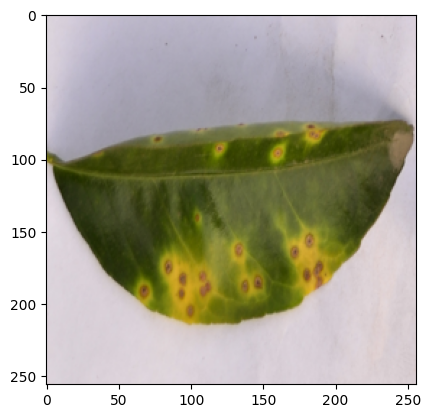

In [3]:
# Replace with your image path
image_path = "/Users/judecao/MUN/Winter2025/DSP/Project/Citrus_indoor/Leaves/canker/45.png"
# image_path = "/Users/judecao/MUN/Winter2025/DSP/Project/Citrus_outdoor/canker/2.jpg"

# 1. Read and preprocess the image
image = cv2.imread(image_path)
if image is None:
    raise ValueError("Image not found or could not be loaded")

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

## 2. Sobel operator

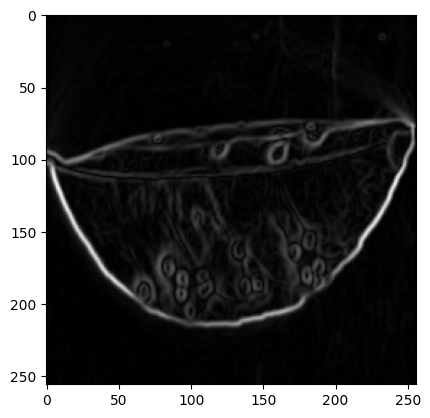

In [4]:
# Convert to gray-scale image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Store intermediate results for visualization
results = {}

# 1. Edge Detection using Sobel operator
# The default is 3 (3x3 kernel). 
# You can increase it to 5 or 7 for smoother edges but less detail, or decrease it for sharper but noisier edges.
# cv2.CV_64F	Desired depth of the output image (64-bit float) – this allows negative gradient values to be preserved
# (1, 0) ~ x gradient
# (0, 1) ~ y gradient
sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=7)
sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=7)
gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
gradient_magnitude = np.uint8(gradient_magnitude * 255 / gradient_magnitude.max())
results['edges'] = gradient_magnitude

plt.imshow(cv2.cvtColor(gradient_magnitude, cv2.COLOR_BGR2RGB))

## 3. Thresholding 

## 3.1. Adaptive

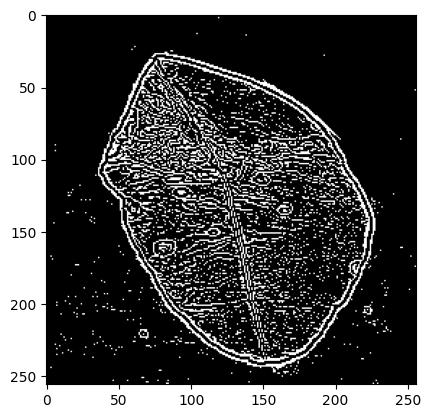

In [ ]:
# 2. Thresholding with adaptive thresholding
thresh = cv2.adaptiveThreshold(
    gradient_magnitude, # the source image to which adaptive thresholding will be applied
    
    255, # This parameter specifies the maximum value assigned to pixels exceeding the threshold. 255 = white
    
    ### Two adaptive methods are available:
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, # Uses a weighted sum of pixel values within the block, where the weights are a Gaussian window, for better performance under uneven lighting conditions, as the Gaussian weighting can smooth out local noise.
    # cv2.ADAPTIVE_THRESH_MEAN_C, # Uses the mean of the pixel values within the block, if the lighting variations are not extreme.
    
    ### Two common thresholding types:
    # cv2.THRESH_BINARY, # Pixels above the threshold are set to the max value (255), others to 0.
    cv2.THRESH_BINARY_INV, # The inverse of THRESH_BINARY, the white pixels represent areas that are below the threshold, while the black pixels represent areas above the threshold. The white pixels are considered the region of interest (ROI)
    
    ### Block size:
    # The size of the neighborhood considered for thresholding. It must be an odd integer greater than 1
    # Smaller block sizes focus on very local regions and may lead to over-segmentation (more noise).
    # Larger block sizes average over a wider region, which can help with noise reduction but may smooth out finer details.
    # Experiment with values typically between 3 and 21 based on the image resolution and complexity. Start with 7 or 9 and adjust based on segmentation quality.
    3, 
    
    ### Constant C:
    # A constant value subtracted from the computed mean or weighted mean. It is used to fine-tune the thresholding.
    # If the thresholding result includes too many unwanted white regions, increase C to make the threshold more stringent.
    # If important features are not highlighted, decrease C to lower the threshold.
    # Typical values range from 2 to 15, depending on the contrast and features of the image.
    3
)
results['threshold'] = thresh

plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))

## 3.2. Adaptive Thresholding with Otsu's Binarization

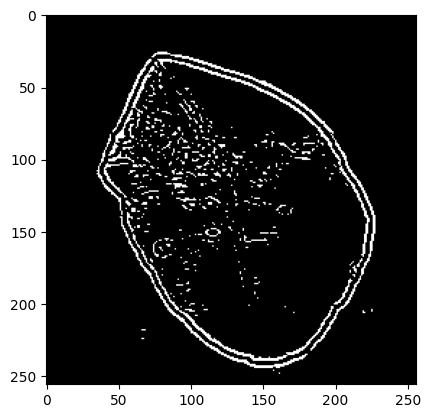

In [ ]:
# Combine Gaussian adaptive and Otsu's thresholding
blurred = cv2.GaussianBlur(gradient_magnitude, (3, 3), 0)
thresh = cv2.adaptiveThreshold(
    blurred, 255, 
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    cv2.THRESH_BINARY_INV, 
    3, 
    3
)

# Apply Otsu's thresholding on the adaptive result
_, combined_thresh = cv2.threshold(thresh, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

results['threshold'] = thresh

plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))

## 3.3. Otsu

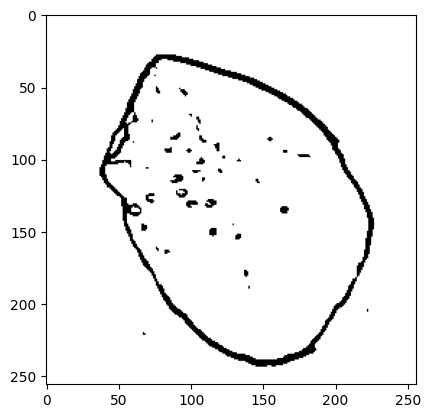

In [ ]:
# Apply Gaussian Blur to reduce noise before thresholding
blurred = cv2.GaussianBlur(gradient_magnitude, (5, 5), 0)

# Apply Otsu's thresholding
_, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

results['threshold'] = thresh

plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))


## 3.4. Canny

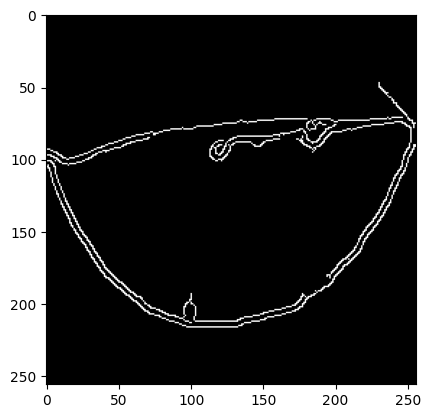

In [121]:
# Apply Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(gradient_magnitude, (5, 5), 0)

# Use Canny edge detection
thresh = cv2.Canny(blurred, 0, 255)

results['threshold'] = thresh

plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))


## 4. Dilation

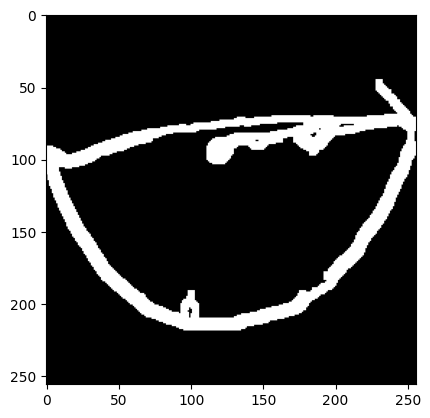

In [123]:
# 3. Dilation using vertical and horizontal structuring elements
vertical_se = np.ones((5, 1), dtype=np.uint8)
horizontal_se = np.ones((1, 5), dtype=np.uint8)
dilated = cv2.dilate(thresh, vertical_se, iterations=1)
dilated = cv2.dilate(dilated, horizontal_se, iterations=1)

results['dilated'] = dilated

plt.imshow(cv2.cvtColor(dilated, cv2.COLOR_BGR2RGB))

## 5. Filling holes (Final mask)

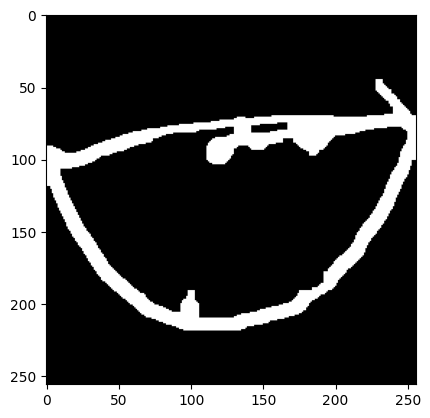

In [124]:
# 4. Filling Holes and Removing Small Areas
# Fill holes using morphological closing
filled_holes = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, np.ones((5,5), dtype=np.uint8))
results['filled_holes'] = filled_holes

plt.imshow(cv2.cvtColor(filled_holes, cv2.COLOR_BGR2RGB))

## 5. Contour

### Normal Contour

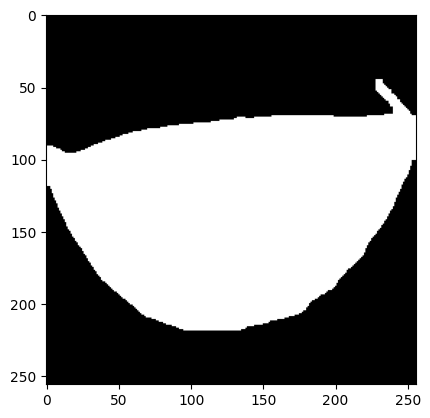

In [125]:
# 1. Find Contours
contours, _ = cv2.findContours(filled_holes, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 2. Select the largest contour (assuming it's the leaf)
if contours:
    largest_contour = max(contours, key=cv2.contourArea)
else:
    raise ValueError("No contours found. Check the edge detection step.")

# 3. Create a Mask from the largest contour
mask = np.zeros_like(filled_holes)
cv2.drawContours(mask, [largest_contour], -1, (255), thickness=cv2.FILLED)

plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))


### Hull Contour

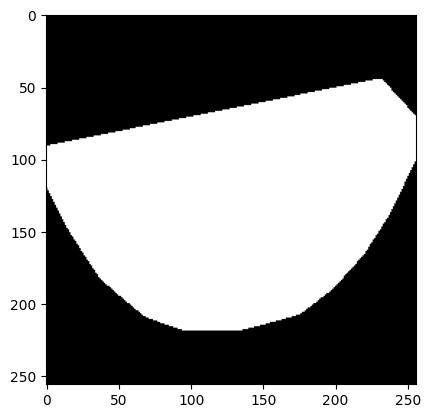

In [127]:
# Find contours in the closed image
contours, _ = cv2.findContours(filled_holes, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a blank mask
mask = np.zeros_like(filled_holes)

# Find the convex hull of the largest contour
if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    hull = cv2.convexHull(largest_contour)

    # Draw the convex hull on the mask
    cv2.drawContours(mask, [hull], -1, (255), thickness=cv2.FILLED)

plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))


### Flood Fill

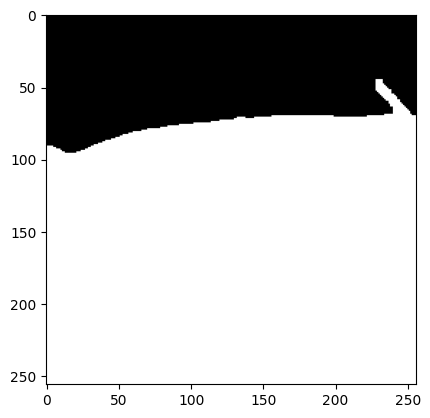

In [128]:
# Make a copy of the edges and define a seed point
flood_fill = filled_holes.copy()
h, w = flood_fill.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)

# Apply the flood fill algorithm
cv2.floodFill(flood_fill, mask, (0, 0), 255)

# Invert the flood filled image
flood_fill_inv = cv2.bitwise_not(flood_fill)

# Combine the edges with the flood fill to get the final mask
mask = filled_holes | flood_fill_inv

# Display the result
plt.imshow(mask, cmap='gray')

## 6. Apply on the original image

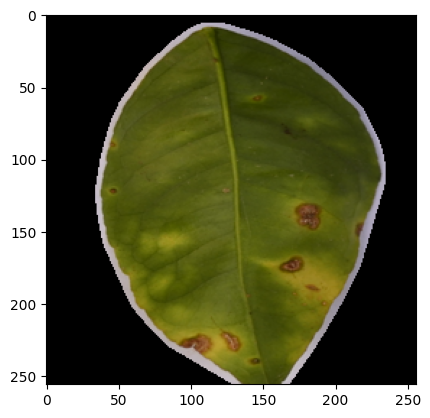

In [112]:
segmented = cv2.bitwise_and(image, image, mask=mask)
results['segmented'] = segmented

plt.imshow(cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB))

# Script (Training)

In [46]:
def segment_citrus_leaf(image_path, sobel_kernel_size, block_size, tuning_constaint, dilation_kernel_size, filling_size):
    # 1. Read and preprocess the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found or could not be loaded")
    
    """
    Step 1: Sobel Operator
    """
    # Convert to gray-scale image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Store intermediate results for visualization
    results = {}

    # 1. Edge Detection using Sobel operator
    # The default is 3 (3x3 kernel). 
    # You can increase it to 5 or 7 for smoother edges but less detail, or decrease it for sharper but noisier edges.
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel_size)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel_size)
    gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    gradient_magnitude = np.uint8(gradient_magnitude * 255 / gradient_magnitude.max())
    results['edges'] = gradient_magnitude

    # plt.imshow(cv2.cvtColor(gradient_magnitude, cv2.COLOR_BGR2RGB))
    
    """
    Step 2: Thresholding
    """
    # 2. Thresholding with adaptive thresholding
    thresh = cv2.adaptiveThreshold(
        gradient_magnitude,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        # cv2.ADAPTIVE_THRESH_MEAN_C,
        # cv2.THRESH_BINARY,
        cv2.THRESH_BINARY_INV,
        block_size,
        tuning_constaint
    )
    results['threshold'] = thresh

    # plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))
    
    """
    Step 3: Dilation
    """
    # 3. Dilation using vertical and horizontal structuring elements
    vertical_se = np.ones((dilation_kernel_size, 1), dtype=np.uint8)
    horizontal_se = np.ones((1, dilation_kernel_size), dtype=np.uint8)
    dilated = cv2.dilate(thresh, vertical_se, iterations=1)
    dilated = cv2.dilate(dilated, horizontal_se, iterations=1)
    results['dilated'] = dilated

    # plt.imshow(cv2.cvtColor(dilated, cv2.COLOR_BGR2RGB))
    
    """
    Step 4: Filling holes (Final mask)
    """
    # 4. Filling Holes and Removing Small Areas
    # Fill holes using morphological closing
    masked = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, np.ones((filling_size,filling_size), dtype=np.uint8))
    results['filled_holes'] = masked

    # plt.imshow(cv2.cvtColor(masked, cv2.COLOR_BGR2RGB))
    
    """
    Step 5: Segmenting
    """
    segmented = cv2.bitwise_and(image, image, mask=masked)
    results['segmented'] = segmented

    # plt.imshow(cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB))
    
    return segmented, masked

In [55]:
def process_images_in_folders(parent_directory: str, segmented_output_dir: str, final_mask_dir: str,
                              sobel_kernel_size, block_size, tuning_constaint, dilation_kernel_size, filling_size
                              ):
    # Iterate over each folder in the parent directory
    for folder_name in os.listdir(parent_directory):
        folder_path = os.path.join(parent_directory, folder_name)
        if os.path.isdir(folder_path):
            # Prepare output directories
            segmented_folder = os.path.join(segmented_output_dir, folder_name)
            final_mask_folder = os.path.join(final_mask_dir, folder_name)
            os.makedirs(segmented_folder, exist_ok=True)
            os.makedirs(final_mask_folder, exist_ok=True)

            # Get all image files in the folder
            image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff'))]
            # Sort image files to maintain a consistent order
            image_files.sort()
            # Process each image file
            for image_file in image_files:
                image_path = os.path.join(folder_path, image_file)
                
                # Apply the processing function
                segmented, masked = segment_citrus_leaf(image_path, sobel_kernel_size, block_size, tuning_constaint, dilation_kernel_size, filling_size)
                segmented_image = segmented
                final_mask = masked

                # Save the processed images using OpenCV
                segmented_output_path = os.path.join(segmented_folder, image_file)
                final_mask_output_path = os.path.join(final_mask_folder, image_file)

                cv2.imwrite(segmented_output_path, segmented_image)
                cv2.imwrite(final_mask_output_path, final_mask)

                print(f'Saved segmented image to: {segmented_output_path}')
                print(f'Saved final mask to: {final_mask_output_path}')

In [56]:
sobel_kernel_size = 3
block_size = 3
tuning_constaint = 5
dilation_kernel_size = 3
filling_size = 9

# Example usage
parent_directory = '/Users/judecao/MUN/Winter2025/DSP/Project/Citrus_indoor/Leaves'
segmented_output_dir = '/Users/judecao/MUN/Winter2025/DSP/Project/Results_indoor/SegmentedOutput'
final_mask_dir = '/Users/judecao/MUN/Winter2025/DSP/Project/Results_indoor/FinalMask'
process_images_in_folders(parent_directory, segmented_output_dir, final_mask_dir,
                          sobel_kernel_size, block_size, tuning_constaint, dilation_kernel_size, filling_size
                          )

Saved segmented image to: /Users/judecao/MUN/Winter2025/DSP/Project/Results_indoor/SegmentedOutput/canker/1.png
Saved final mask to: /Users/judecao/MUN/Winter2025/DSP/Project/Results_indoor/FinalMask/canker/1.png
Saved segmented image to: /Users/judecao/MUN/Winter2025/DSP/Project/Results_indoor/SegmentedOutput/canker/10.png
Saved final mask to: /Users/judecao/MUN/Winter2025/DSP/Project/Results_indoor/FinalMask/canker/10.png
Saved segmented image to: /Users/judecao/MUN/Winter2025/DSP/Project/Results_indoor/SegmentedOutput/canker/100.png
Saved final mask to: /Users/judecao/MUN/Winter2025/DSP/Project/Results_indoor/FinalMask/canker/100.png
Saved segmented image to: /Users/judecao/MUN/Winter2025/DSP/Project/Results_indoor/SegmentedOutput/canker/101.png
Saved final mask to: /Users/judecao/MUN/Winter2025/DSP/Project/Results_indoor/FinalMask/canker/101.png
Saved segmented image to: /Users/judecao/MUN/Winter2025/DSP/Project/Results_indoor/SegmentedOutput/canker/102.png
Saved final mask to: /Us

# Script (Final Result)

In [7]:
import os
import cv2
import numpy as np
from skimage.morphology import dilation, square, remove_small_objects
from scipy.ndimage import label
import matplotlib.pyplot as plt

def segment_citrus_leaf(image_path, sobel_kernel_size, dilation_kernel_size, filling_kernel_size):
    # 1. Read and preprocess the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found or could not be loaded")
    
    """
    Step 1: Sobel Operator
    """
    # Convert to gray-scale image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Store intermediate results for visualization
    results = {}

    # 1. Edge Detection using Sobel operator
    # The default is 3 (3x3 kernel). 
    # You can increase it to 5 or 7 for smoother edges but less detail, or decrease it for sharper but noisier edges.
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel_size)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel_size)
    gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    gradient_magnitude = np.uint8(gradient_magnitude * 255 / gradient_magnitude.max())
    results['edges'] = gradient_magnitude

    # plt.imshow(cv2.cvtColor(gradient_magnitude, cv2.COLOR_BGR2RGB))
    
    """
    Step 2: Thresholding
    """
    # Apply Gaussian Blur to reduce noise
    blurred = cv2.GaussianBlur(gradient_magnitude, (5, 5), 0)

    # Use Canny edge detection
    thresh = cv2.Canny(blurred, 0, 255)

    results['threshold'] = thresh

    # plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))
    
    """
    Step 3: Dilation
    """
    # 3. Dilation using vertical and horizontal structuring elements
    vertical_se = np.ones((dilation_kernel_size, 1), dtype=np.uint8)
    horizontal_se = np.ones((1, dilation_kernel_size), dtype=np.uint8)
    dilated = cv2.dilate(thresh, vertical_se, iterations=1)
    dilated = cv2.dilate(dilated, horizontal_se, iterations=1)
    results['dilated'] = dilated
    
    """
    Step 4: Filling holes
    """
    # 4. Filling Holes and Removing Small Areas
    # Fill holes using morphological closing
    filled_holes = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, np.ones((filling_kernel_size,filling_kernel_size), dtype=np.uint8))
    results['filled_holes'] = filled_holes
    
    """
    Step 5: Find Contours, select largest contour and create the mask
    """
    # # 1. Find Contours
    contours, _ = cv2.findContours(filled_holes, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 2. Select the largest contour (assuming it's the leaf)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        
    else:
        raise ValueError("No contours found. Check the edge detection step.")

    # 3. Create a Mask from the largest contour
    mask = np.zeros_like(filled_holes)
    cv2.drawContours(mask, [largest_contour], -1, (255), thickness=cv2.FILLED)
    results['masked'] = mask
    
    """
    Step 6: Segmenting
    """
    segmented = cv2.bitwise_and(image, image, mask=mask)
    results['segmented'] = segmented

    # plt.imshow(cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB))
    
    return segmented, mask, results

def visualize_results(results, original_image):
    """Visualize intermediate results for each step."""
    plt.figure(figsize=(15, 10))
    
    steps = [
        ('Original Image', original_image),
        ('Sobel edge detection', results['edges']),
        ('Thresholded', results['threshold']),
        ('Dilated', results['dilated']),
        ('Filled Holes', results['filled_holes']),
        ('Final Mask', results['masked']),
        ('Segmented Image', results['segmented'])
    ]
    
    for i, (title, image) in enumerate(steps, 1):
        plt.subplot(3, 3, i)
        if len(image.shape) == 2:  # Grayscale
            plt.imshow(image, cmap='gray')
        else:  # Color image (BGR)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    try:
        # Replace with your image path
        image_path = "/Users/judecao/MUN/Winter2025/DSP/Project/Citrus/Leaves/canker/1.png.png"
        
        sobel_kernel_size = 5
        dilation_kernel_size = 5
        filling_kernel_size = 5
        
        # Perform segmentation
        segmented_image, final_mask, results = segment_citrus_leaf(image_path, sobel_kernel_size, dilation_kernel_size, filling_kernel_size)
        
        # Visualize all steps
        original_image = cv2.imread(image_path)
        visualize_results(results, original_image)
        
        # Save results
        cv2.imwrite('segmented_output.jpg', segmented_image)
        cv2.imwrite('final_mask.jpg', final_mask)
        
    except Exception as e:
        print(f"Error: {str(e)}")

# Required libraries:
# pip install opencv-python numpy scikit-image scipy matplotlib

Error: segment_citrus_leaf() missing 3 required positional arguments: 'sobel_kernel_size', 'dilation_kernel_size', and 'filling_kernel_size'


In [14]:
results['threshold']

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

# Ground truth

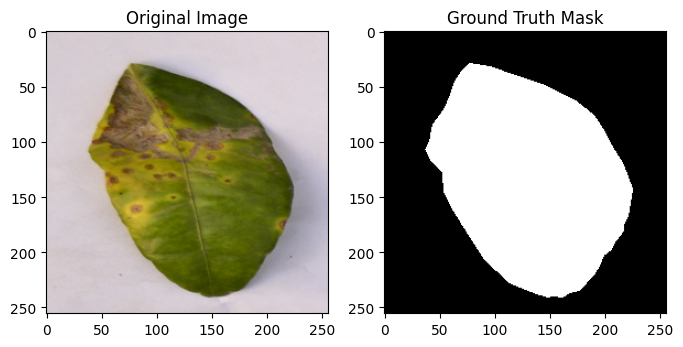

In [1]:
import json
import numpy as np
import cv2
from PIL import Image

# Paths to the image and the annotation JSON file
image_path = '/Users/judecao/MUN/Winter2025/DSP/Project/Citrus_indoor/Leaves/canker/1.png'
json_path = '/Users/judecao/MUN/Winter2025/DSP/Project/GroundTruth_indoor/canker/1.json'

# Load the LabelMe JSON file
with open(json_path) as f:
    data = json.load(f)

# Load the original image
image = np.array(Image.open(image_path))

# Create a blank mask with the same size as the image
mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

# Draw polygons on the mask
for shape in data['shapes']:
    points = np.array(shape['points'], dtype=np.int32)
    cv2.fillPoly(mask, [points], color=255)  # White mask for the leaf region

# Save the binary mask as an image
mask_path = '/Users/judecao/MUN/Winter2025/DSP/Project/GroundTruth_indoor/canker/1.png'
cv2.imwrite(mask_path, mask)

# Visualize the mask
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Ground Truth Mask')

plt.show()


# Precision

In [2]:
import cv2
import numpy as np
from sklearn.metrics import jaccard_score, f1_score, precision_score, recall_score

# Load the ground truth mask and the predicted mask
# ground_truth and predicted_mask are grayscale images, typically with pixel values ranging from 0 to 255.
ground_truth = cv2.imread('/Users/judecao/MUN/Winter2025/DSP/Project/GroundTruth_indoor/canker/1.png', cv2.IMREAD_GRAYSCALE)
predicted_mask = cv2.imread('/Users/judecao/MUN/Winter2025/DSP/Project/Results_indoor/FinalMask/canker/1.png', cv2.IMREAD_GRAYSCALE)

# Ensure the masks are binary (0 and 1)
# (ground_truth > 127) creates a boolean array where: 
# 127 is the midpoint between 0 and 255. Any pixel with a brightness higher than 127 is considered white, others are black.
# True (1): Pixel value is greater than 127 (considered white, or the region of interest).
# False (0): Pixel value is 127 or below (considered black, or the background).
ground_truth = (ground_truth > 127).astype(np.uint8)
predicted_mask = (predicted_mask > 127).astype(np.uint8)

# Flatten the masks for metric calculations: converts a 2D image array into a 1D array.
# Metric Functions like precision_score, jaccard_score, and f1_score require the input as 1D arrays. 
# Converts each pixel into a data point for pixel-wise comparison.
ground_truth_flat = ground_truth.flatten()
predicted_mask_flat = predicted_mask.flatten()

# Calculate Precision
# Precision = TP / (TP + FP)
# TP (True Positive): Correctly identified leaf pixels.
# FP (False Positive): Background pixels wrongly identified as leaf pixels.
precision = precision_score(ground_truth_flat, predicted_mask_flat)
print(f"Precision: {precision:.4f}")

# Calculate IoU (Jaccard Score)
# Measures the overlap between the predicted and ground truth masks.
# Values range from 0 to 1, where 1 means perfect overlap.
# IoU emphasizes the overlap relative to the union of both regions.
iou = jaccard_score(ground_truth_flat, predicted_mask_flat)
print(f"IoU: {iou:.4f}")

# Calculate Dice Coefficient (F1 Score)
# The Dice coefficient is another measure of overlap between the predicted and ground truth regions.
# The f1_score() function from scikit-learn calculates the Dice coefficient.
# The Dice score is often used in medical image segmentation.
dice = f1_score(ground_truth_flat, predicted_mask_flat)
print(f"Dice Coefficient: {dice:.4f}")

# Calculate Pixel Accuracy
# TP (True Positives): Pixels correctly classified as leaf.
# TN (True Negatives): Pixels correctly classified as background.
# FP (False Positives): Background pixels wrongly identified as leaf.
# FN (False Negatives): Leaf pixels missed and classified as background.
tp = np.sum((predicted_mask == 1) & (ground_truth == 1))
tn = np.sum((predicted_mask == 0) & (ground_truth == 0))
fp = np.sum((predicted_mask == 1) & (ground_truth == 0))
fn = np.sum((predicted_mask == 0) & (ground_truth == 1))

pixel_accuracy = (tp + tn) / (tp + tn + fp + fn)
print(f"Pixel Accuracy: {pixel_accuracy:.4f}")

# Calculate Recall (Optional)
recall = recall_score(ground_truth_flat, predicted_mask_flat)
print(f"Recall: {recall:.4f}")


Precision: 0.9068
IoU: 0.9068
Dice Coefficient: 0.9511
Pixel Accuracy: 0.9577
Recall: 1.0000


# Latex

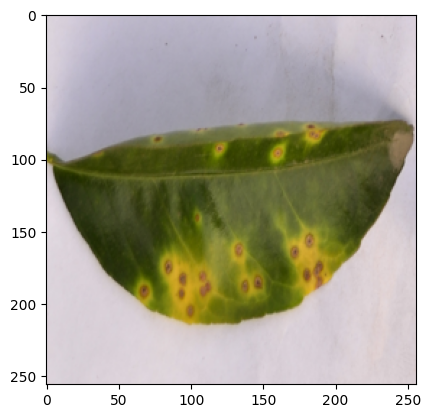

In [4]:
# Replace with your image path
image_path = "/Users/judecao/MUN/Winter2025/DSP/Project/Citrus_indoor/Leaves/canker/45.png"
# image_path = "/Users/judecao/MUN/Winter2025/DSP/Project/Citrus_outdoor/canker/2.jpg"

# 1. Read and preprocess the image
image = cv2.imread(image_path)
if image is None:
    raise ValueError("Image not found or could not be loaded")

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

## Sobel

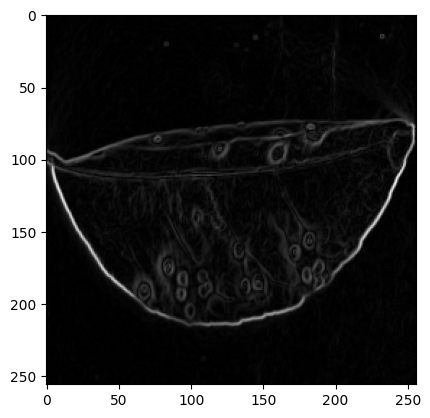

In [5]:
# Convert to gray-scale image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Store intermediate results for visualization
results = {}

# 1. Edge Detection using Sobel operator
# The default is 3 (3x3 kernel). 
# You can increase it to 5 or 7 for smoother edges but less detail, or decrease it for sharper but noisier edges.
sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
gradient_magnitude = np.uint8(gradient_magnitude * 255 / gradient_magnitude.max())
results['edges'] = gradient_magnitude

plt.imshow(cv2.cvtColor(gradient_magnitude, cv2.COLOR_BGR2RGB))

In [15]:
sobel_x.size

65536

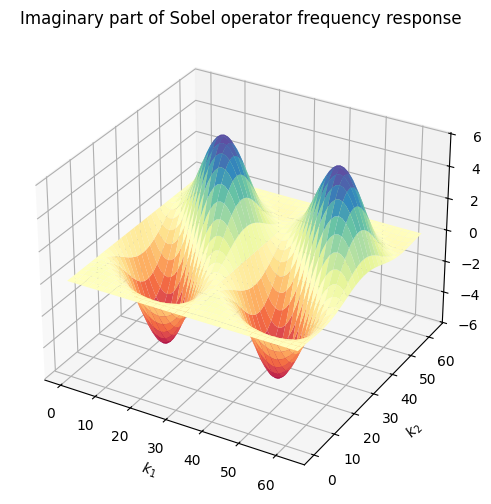

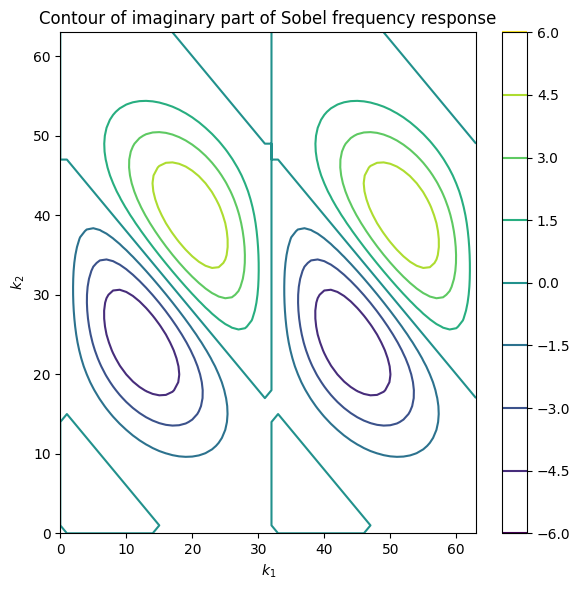

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, fftshift

# Define the Sobel operator in spatial domain (horizontal)
sobel_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
], dtype=np.float64)

# Zero-pad the Sobel operator to 64x64
pad_size = (64, 64)
sobel_padded = np.zeros(pad_size, dtype=np.float64)
sobel_padded[:sobel_x.shape[0], :sobel_x.shape[1]] = sobel_x

# Compute the 2D Fourier transform and shift the zero frequency to center
sobel_fft = fft2(sobel_padded)
sobel_fft_shifted = fftshift(sobel_fft)
sobel_fft_imag = np.imag(sobel_fft_shifted)

# Plot the imaginary part (3D surface plot)
k1 = np.arange(pad_size[1])
k2 = np.arange(pad_size[0])
K1, K2 = np.meshgrid(k1, k2)

fig1 = plt.figure(figsize=(10, 6))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot_surface(K1, K2, sobel_fft_imag, cmap='Spectral')
ax1.set_title('Imaginary part of Sobel operator frequency response')
ax1.set_xlabel('$k_1$')
ax1.set_ylabel('$k_2$')
ax1.set_zlabel('$|H(k_1, k_2)|$')

# Plot the contour of the imaginary part
fig2, ax2 = plt.subplots(figsize=(6, 6))
contour = ax2.contour(K1, K2, sobel_fft_imag, cmap='viridis')
ax2.set_title('Contour of imaginary part of Sobel frequency response')
ax2.set_xlabel('$k_1$')
ax2.set_ylabel('$k_2$')
plt.colorbar(contour, ax=ax2)

plt.tight_layout()
plt.show()


In [29]:
sobel_7x7_x

array([[-1., -2., -1.],
       [ 0.,  0.,  0.],
       [ 1.,  2.,  1.]], dtype=float32)

In [36]:
kx, ky = cv2.getDerivKernels(dx=1, dy=0, ksize=5, normalize=False)
sobel_7x7_x = np.outer(kx, ky.T)  # 2D kernel
kx

array([[-1.],
       [-2.],
       [ 0.],
       [ 2.],
       [ 1.]], dtype=float32)

In [37]:
ky

array([[1.],
       [4.],
       [6.],
       [4.],
       [1.]], dtype=float32)

In [38]:
sobel_7x7_x

array([[ -1.,  -4.,  -6.,  -4.,  -1.],
       [ -2.,  -8., -12.,  -8.,  -2.],
       [  0.,   0.,   0.,   0.,   0.],
       [  2.,   8.,  12.,   8.,   2.],
       [  1.,   4.,   6.,   4.,   1.]], dtype=float32)